In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import csv

In [2]:
# Function to load GloVe embeddings
def load_glove_embeddings(file_path, embedding_dim=100):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
    return embeddings_index

In [3]:
# Data Loading and Preprocessing with GloVe
def preprocess_data(df, glove_embeddings, embedding_dim=100, max_seq_len=20):
    df = df[['text', 'airline_sentiment']].dropna()

    # Basic sentiment mapping
    sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['airline_sentiment'] = df['airline_sentiment'].map(sentiment_mapping)

    # Tokenization and vocabulary creation
    def tokenize(text):
        return text.lower().split()

    vocab = Counter()
    for text in df['text']:
        vocab.update(tokenize(text))

    # Create word to index mapping based on available GloVe embeddings
    word_to_idx = {'<UNK>': 0}  
    idx = 1
    for word in glove_embeddings.keys():
        if word in vocab:
            word_to_idx[word] = idx
            idx += 1

    # Create embedding matrix with the correct size (include one extra row for '<UNK>')
    embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
    for word, i in word_to_idx.items():
        if word == '<UNK>':
            continue
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    def text_to_sequence(text):
        return [word_to_idx.get(word, 0) for word in tokenize(text)]

    df['text_seq'] = df['text'].apply(text_to_sequence)
    df['text_seq'] = df['text_seq'].apply(lambda x: x[:max_seq_len] + [0] * (max_seq_len - len(x)))

    # Split dataset into training, validation, and test sets 80-15-5
    train_size = int(len(df) * 0.8)
    val_size = int(len(df) * 0.15)

    train_data = df[:train_size]
    val_data = df[train_size:train_size + val_size]
    test_data = df[train_size + val_size:]

    return train_data, val_data, test_data, embedding_matrix


In [4]:
# Define the RNN model
class RNN_scratch:
    def __init__(self, input_size, hidden_size, output_size, embedding_matrix=None):
        self.embedding_matrix = embedding_matrix
        self.input_size = input_size  # Size of the embedding dimension
        self.U = np.random.randn(hidden_size, input_size) * 0.01
        self.W = np.random.randn(hidden_size, hidden_size) * 0.01
        self.V = np.random.randn(output_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, x):
        T = len(x)  # Number of time steps (length of input sequence)
        hidden_size = self.U.shape[0]
        output_size = self.V.shape[0]

        self.h = np.zeros((T, hidden_size))
        self.o = np.zeros((T, output_size))

        for t in range(T):
            # Use GloVe embedding for the input word
            xt = self.embedding_matrix[x[t]].reshape(-1, 1)

            # Update the hidden state
            self.h[t] = np.tanh(self.U @ xt + self.W @ self.h[t-1].reshape(-1, 1) + self.bh).reshape(-1)

            # Calculate the output using softmax
            self.o[t] = self.softmax(self.V @ self.h[t].reshape(-1, 1) + self.by).reshape(-1)

        return self.o[-1]  # Return the output of the last time step

    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)

    def backward(self, x, y, learning_rate=0.001):
        y_one_hot = np.zeros(self.o.shape[-1])
        y_one_hot[y] = 1

        delta_y = self.o[-1] - y_one_hot

        dV = delta_y.reshape(-1, 1) @ self.h[-1].reshape(1, -1)
        dby = delta_y.reshape(-1, 1)

        delta_h = self.V.T @ delta_y.reshape(-1, 1)

        for t in reversed(range(len(x))):
            delta_h_raw = (1 - self.h[t] ** 2) * delta_h.reshape(-1)

            xt = self.embedding_matrix[x[t]].reshape(-1, 1)

            dU = delta_h_raw.reshape(-1, 1) @ xt.T
            dW = delta_h_raw.reshape(-1, 1) @ self.h[t-1].reshape(1, -1)
            dbh = delta_h_raw.reshape(-1, 1)

            self.U -= learning_rate * dU
            self.W -= learning_rate * dW
            self.V -= learning_rate * dV
            self.bh -= learning_rate * dbh
            self.by -= learning_rate * dby

            if t > 0:
                delta_h = self.W.T @ delta_h_raw.reshape(-1, 1)

In [5]:
# Calculate metrics function
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    return accuracy, precision, recall, f1

In [6]:
# Training function with metrics
def train_rnn_with_metrics(model, train_data, val_data, epochs=10, learning_rate=0.001, save_path="part_1.1_rnn_scratch.pkl"):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        total_train_loss = 0
        y_true_train = []
        y_pred_train = []

        # Training loop
        for _, row in train_data.iterrows():
            x = np.array(row['text_seq'])
            y = row['airline_sentiment']

            # Forward pass
            o = model.forward(x)
            loss = -np.log(o[y])
            total_train_loss += loss

            model.backward(x, y, learning_rate=learning_rate)

            # Store true and predicted values for metrics
            y_true_train.append(y)
            y_pred_train.append(np.argmax(o))

        avg_train_loss = total_train_loss / len(train_data)
        train_losses.append(avg_train_loss)

        # Calculate training metrics
        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(y_true_train, y_pred_train)

        # Validation loss calculation
        total_val_loss = 0
        y_true_val = []
        y_pred_val = []

        for _, row in val_data.iterrows():
            x = np.array(row['text_seq'])
            y = row['airline_sentiment']

            o = model.forward(x)
            loss = -np.log(o[y])
            total_val_loss += loss

            # Store true and predicted values for metrics
            y_true_val.append(y)
            y_pred_val.append(np.argmax(o))

        avg_val_loss = total_val_loss / len(val_data)
        val_losses.append(avg_val_loss)

        # Calculate validation metrics
        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(y_true_val, y_pred_val)

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        print(f"Training Metrics: Accuracy = {train_accuracy:.4f}, Precision = {train_precision:.4f}, Recall = {train_recall:.4f}, F1 Score = {train_f1:.4f}")
        print(f"Validation Metrics: Accuracy = {val_accuracy:.4f}, Precision = {val_precision:.4f}, Recall = {val_recall:.4f}, F1 Score = {val_f1:.4f}")

        # Save model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            with open(save_path, 'wb') as f:
                pickle.dump(model, f)

    return train_losses, val_losses

In [7]:
def evaluate_and_save_results(model, test_data, output_csv="test_results.csv"):
    # Define the reverse sentiment mapping
    sentiment_reverse_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    
    results = []
    y_true_test = []
    y_pred_test = []

    for _, row in test_data.iterrows():
        tweet_id = row.get('tweet_id', 'N/A')  
        tweet_text = row['text']
        actual_sentiment = row['airline_sentiment']

        x = np.array(row['text_seq'])
        o = model.forward(x)
        predicted_sentiment = np.argmax(o)

        # Convert actual and predicted sentiment back to strings
        actual_sentiment_str = sentiment_reverse_mapping[actual_sentiment]
        predicted_sentiment_str = sentiment_reverse_mapping[predicted_sentiment]

        # Store for CSV output
        results.append([tweet_id, tweet_text, actual_sentiment_str, predicted_sentiment_str])
        y_true_test.append(actual_sentiment)
        y_pred_test.append(predicted_sentiment)

    # Save results to a CSV
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Tweet Id', 'Tweet Text', 'Actual Sentiment', 'Predicted Sentiment'])
        csv_writer.writerows(results)

    # Calculate test metrics
    test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(y_true_test, y_pred_test)
    print(f"Test Metrics: Accuracy = {test_accuracy:.4f}, Precision = {test_precision:.4f}, Recall = {test_recall:.4f}, F1 Score = {test_f1:.4f}")


In [8]:
# Load GloVe embeddings
glove_embeddings = load_glove_embeddings('glove.6B.100d.txt', embedding_dim=100)

Loaded 400000 word vectors from GloVe.


In [9]:
# Data loading and preprocessing
df = pd.read_csv('Tweets_q1_main.csv')
train_data, val_data, test_data, embedding_matrix = preprocess_data(df, glove_embeddings, embedding_dim=100)

In [10]:
# Model parameters
input_size = 100  # GloVe embedding size
hidden_size = 128
output_size = 3  # Negative, Neutral, Positive

# Create an instance of the RNN model
rnn = RNN_scratch(input_size, hidden_size, output_size, embedding_matrix=embedding_matrix)

In [11]:
# Train the RNN model and obtain training and validation losses
train_losses, val_losses = train_rnn_with_metrics(rnn, train_data, val_data, epochs=50, learning_rate=0.001)

Epoch 1: Train Loss = 0.9392, Val Loss = 0.9203
Training Metrics: Accuracy = 0.5717, Precision = 0.1906, Recall = 0.3332, F1 Score = 0.2425
Validation Metrics: Accuracy = 0.5933, Precision = 0.1978, Recall = 0.3333, F1 Score = 0.2483
Epoch 2: Train Loss = 0.9192, Val Loss = 0.9053
Training Metrics: Accuracy = 0.5714, Precision = 0.2988, Recall = 0.3393, F1 Score = 0.2627
Validation Metrics: Accuracy = 0.5933, Precision = 0.1978, Recall = 0.3333, F1 Score = 0.2483
Epoch 3: Train Loss = 0.8764, Val Loss = 0.8284
Training Metrics: Accuracy = 0.6054, Precision = 0.4936, Recall = 0.4317, F1 Score = 0.4276
Validation Metrics: Accuracy = 0.6447, Precision = 0.5381, Recall = 0.4681, F1 Score = 0.4472
Epoch 4: Train Loss = 0.8237, Val Loss = 0.8185
Training Metrics: Accuracy = 0.6382, Precision = 0.5296, Recall = 0.4981, F1 Score = 0.4945
Validation Metrics: Accuracy = 0.6573, Precision = 0.5582, Recall = 0.4858, F1 Score = 0.4668
Epoch 5: Train Loss = 0.8093, Val Loss = 0.8146
Training Metrics

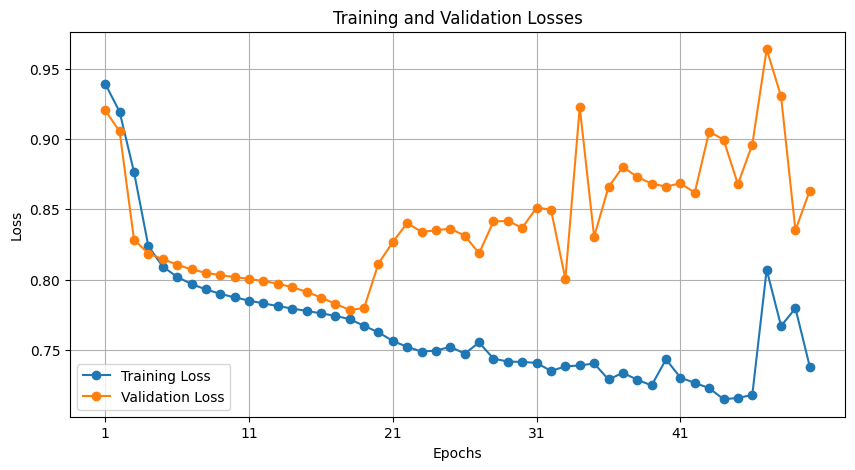

In [12]:
import matplotlib.pyplot as plt

# Number of epochs
epochs = range(1, len(train_losses) + 1)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

# Add title and labels
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(epochs), 10))  # Set x-ticks to be the epoch numbers
plt.legend()  # Show legend
plt.grid()  # Add grid for better readability

# Show the plot
plt.show()

In [13]:
# Load the best model for evaluation
with open("part_1.1_rnn_scratch.pkl", "rb") as f:
    best_rnn = pickle.load(f)

# Evaluate the model on training, validation, and test sets and save results for the test set
evaluate_and_save_results(best_rnn, test_data, output_csv="scratch_rnn.csv")

Test Metrics: Accuracy = 0.6520, Precision = 0.5406, Recall = 0.5033, F1 Score = 0.4636


In [14]:
# import pickle

# # Save train and validation losses to a file
# with open('scratch_losses.pkl', 'wb') as f:
#     pickle.dump({'train_losses': train_losses, 'val_losses': val_losses}, f)
